In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats
import sklearn.model_selection
import sklearn.preprocessing
import sklearn.tree
from tqdm import tqdm

import gradient_boosting

%load_ext autoreload
%autoreload 2

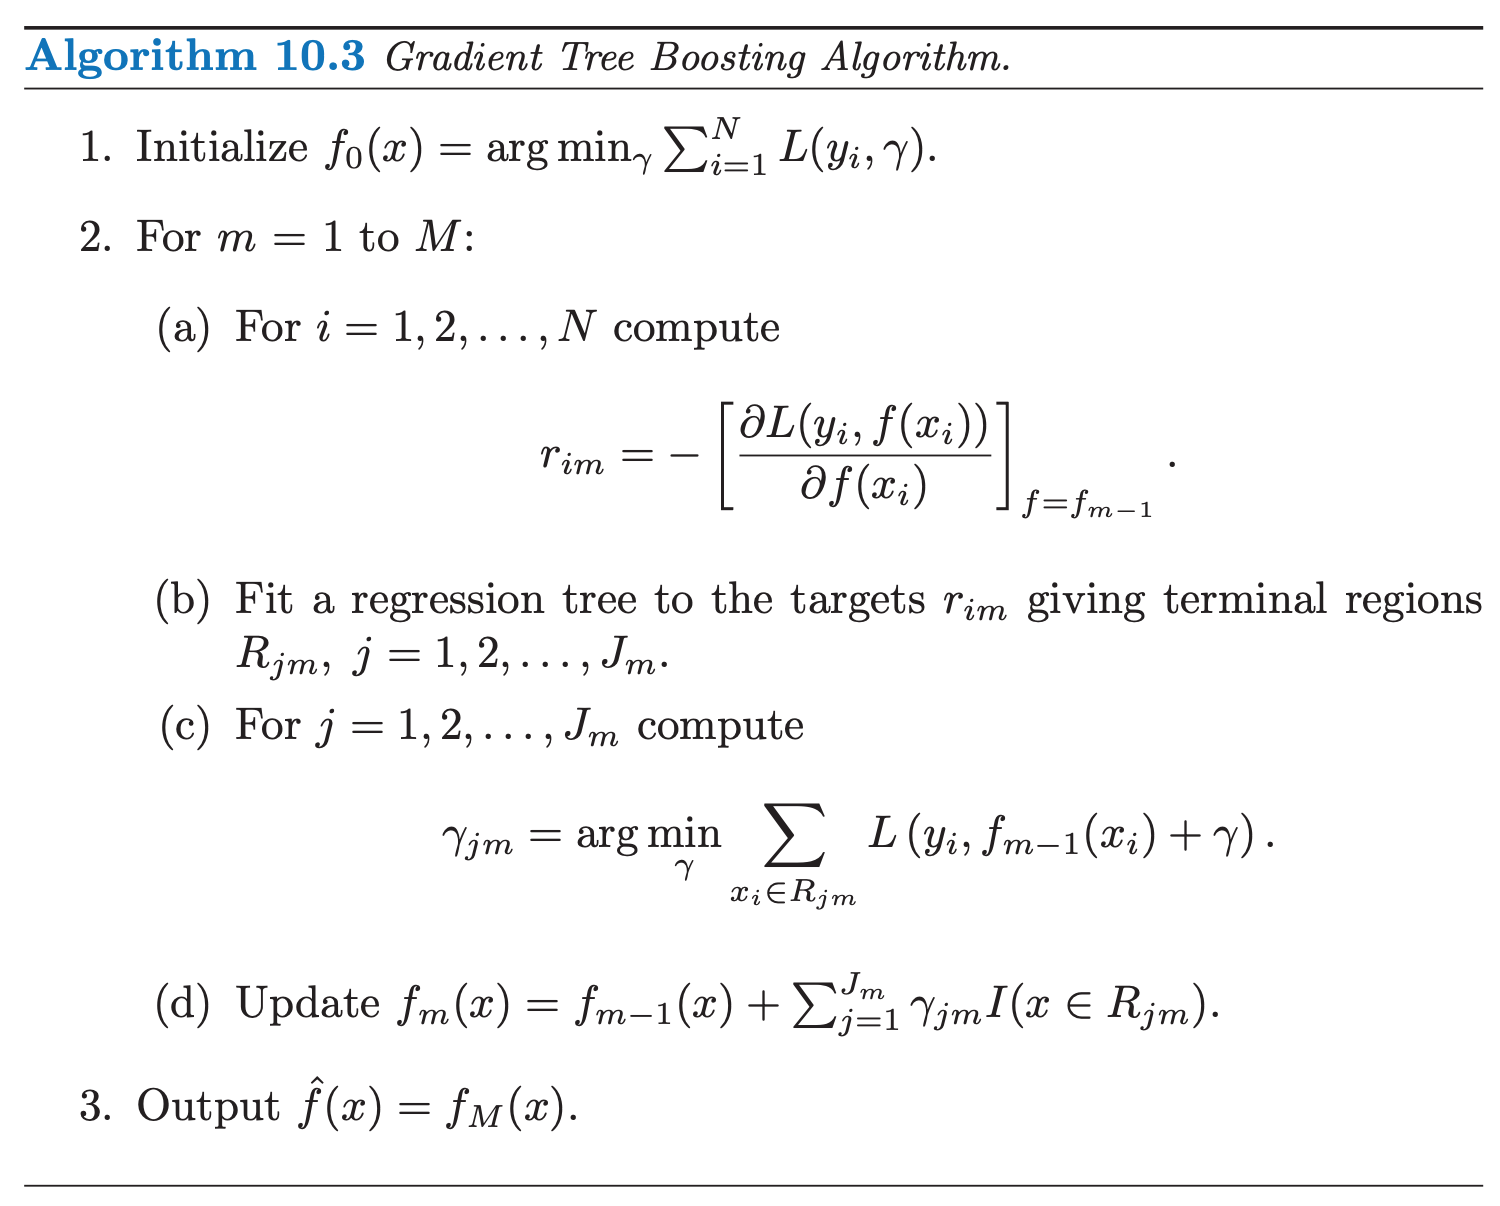

We'll implement gradient boosting and then use it to approximate a 2D-gaussian

In [2]:
MEAN = [0, 0]
COVARIANCE = [[2.0, 0.3], [0.3, 0.5]]

# Make training data

In [3]:
df_examples = gradient_boosting.make_train_data(MEAN, COVARIANCE)

In [4]:
df_examples.head(2)

,x1,x2,label
0,-0.499269,2.021509,0.001253
1,-1.610627,1.750875,0.001112


In [5]:
X_train = df_examples[['x1', 'x2']]
y_train = df_examples['label']

# Visualize training data in 3D

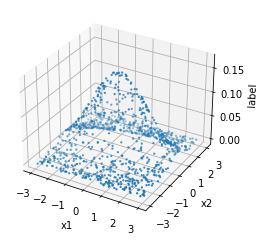

In [6]:
gradient_boosting.visualize_training_data(
    df_examples.sample(1000),
    x_col="x1",
    y_col="x2",
    z_col="label",
)

# Make test data

Not, test data are made to be on the grids delibrately to enable surface plot.

In [7]:
x1s_test, x2s_test = np.mgrid[
    -3:3:0.05,
    -3:3:0.05,
]

X_test = np.concatenate(
    [
        x1s_test.reshape(-1, 1),
        x2s_test.reshape(-1, 1),
    ],
    axis=1,
)

In [8]:
x1s_test.shape

(120, 120)

In [9]:
x2s_test.shape

(120, 120)

In [10]:
X_test

array([[-3.  , -3.  ],
       [-3.  , -2.95],
       [-3.  , -2.9 ],
       ...,
       [ 2.95,  2.85],
       [ 2.95,  2.9 ],
       [ 2.95,  2.95]])

In [11]:
y_test = scipy.stats.multivariate_normal(MEAN, COVARIANCE).pdf(X_test)

In [12]:
y_test

array([1.38624596e-05, 1.82955336e-05, 2.40139518e-05, ...,
       3.24555431e-05, 2.48426903e-05, 1.89113327e-05])

# Visualize the learned function with increasing number of estimators

CPU times: user 2.02 s, sys: 304 ms, total: 2.33 s
Wall time: 994 ms


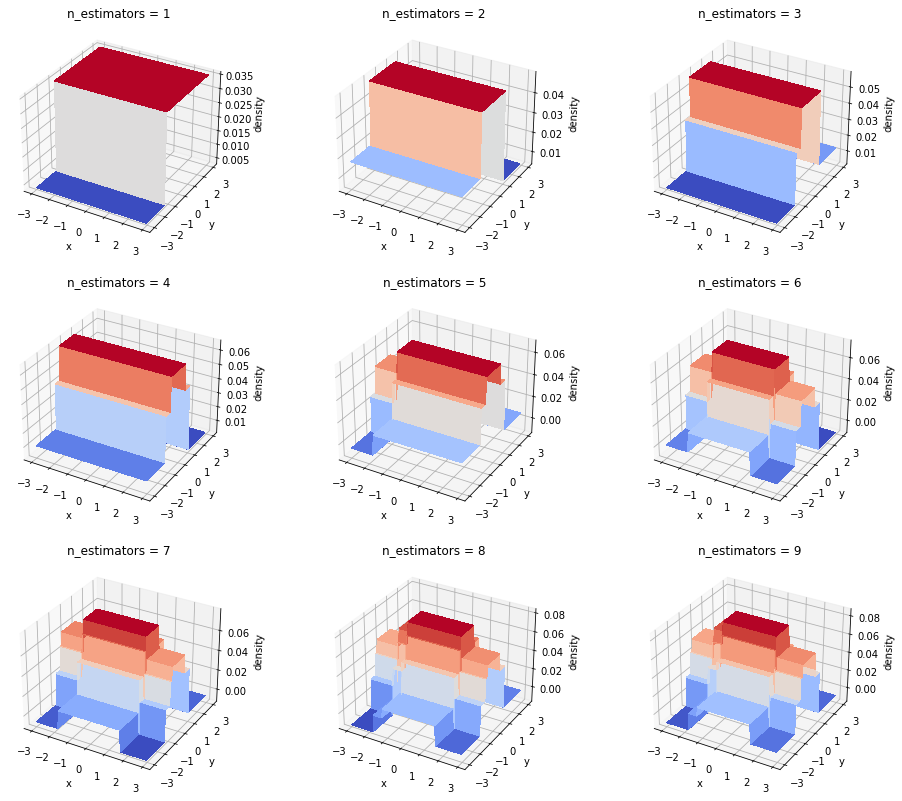

In [23]:
%%time
fig = plt.figure(figsize=(16, 14))

for k in range(1, 10):
    regressor = gradient_boosting.GradientBoostingRegressor(
        learning_rate=1,
        n_estimators=k,
    )
    regressor.fit(X_train, y_train, verbose=False)
    preds_test = regressor.predict(X_test, verbose=False)

    ax = fig.add_subplot(3, 3, k, projection="3d")
    ax.plot_surface(
        x1s_test,
        x2s_test,
        preds_test.reshape(len(x1s_test), len(x1s_test)),
        rstride=1,
        cstride=1,
        cmap=matplotlib.cm.coolwarm,
        linewidth=0,
        antialiased=False,
    )

    ax.set(
        xlabel="x",
        ylabel="y",
        zlabel="density",
        title=f"n_estimators = {k}",
    )

# Experiment gradient boosting with a large number of estimators, and different learning_rates

In [24]:
outputs = [
    {"learning_rate": 1},
    {"learning_rate": 0.01},
]

In [25]:
for output in outputs:
    regressor = gradient_boosting.GradientBoostingRegressor(
        learning_rate=output['learning_rate'],
        n_estimators=2000,
    )
    
    regressor.fit(X_train, y_train, X_val=X_test, y_val=y_test)
    
    output['regressor'] = regressor
    output['y_preds_train'] = regressor.predict(X_train)
    output['y_preds_test'] = regressor.predict(X_test)

100%|██████████| 2000/2000 [00:00<00:00, 4150.30it/s]


# Visualize learning curve and predicted values

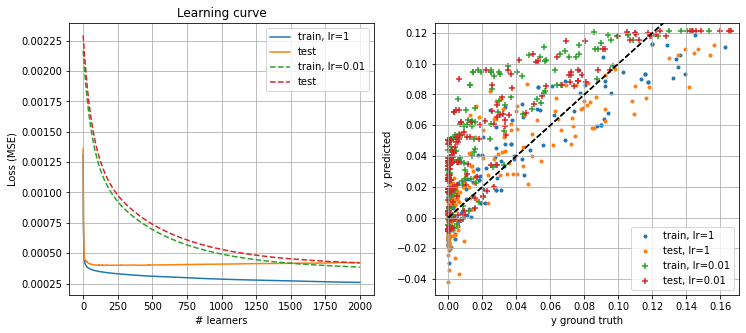

In [28]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes = axes.ravel()

for k, (output, linestyle, marker) in enumerate(zip(outputs, ["-", "--"], [".", "+"])):
    axes[0].plot(
        output["regressor"].loss_history,
        linestyle=linestyle,
        label=f"train, lr={output['learning_rate']}",
    )
    axes[0].plot(
        output["regressor"].loss_val_history,
        linestyle=linestyle,
        label="test",
    )
    axes[0].set(xlabel="# learners", ylabel="Loss (MSE)", title="Learning curve")

    idx_train = np.random.randint(low=0, high=len(y_train) - 1, size=200)
    axes[1].scatter(
        y_train[idx_train],
        output["y_preds_train"][idx_train],
        marker=marker,
        label=f"train, lr={output['learning_rate']}",
    )

    idx_test = np.random.randint(low=0, high=len(y_test) - 1, size=200)
    axes[1].scatter(
        y_test[idx_test],
        output["y_preds_test"][idx_test],
        marker=marker,
        label=f"test, lr={output['learning_rate']}",
    )

    xlim = axes[1].get_xlim()
    ylim = axes[1].get_ylim()
    axes[1].plot([0, 1], [0, 1], '--', color='black')
    axes[1].set(xlabel="y ground truth", ylabel="y predicted", xlim=xlim, ylim=ylim)
    
    

for _ax in axes:
    _ax.grid()
    _ax.legend()

When learning_rate = 0.01, the model tends to overpredict y.

# Visualize learned functions in 3D

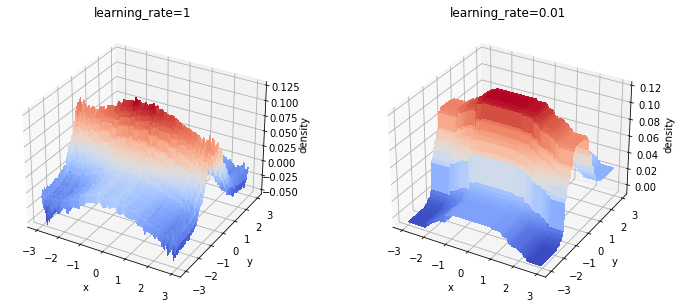

In [29]:
fig = plt.figure(figsize=(12, 5))

for k, output in enumerate(outputs):
    ax = fig.add_subplot(1, 2, k + 1, projection="3d")
    ax.plot_surface(
        x1s_test,
        x2s_test,
        output["y_preds_test"].reshape(len(x1s_test), len(x1s_test)),
        rstride=1,
        cstride=1,
        cmap=matplotlib.cm.coolwarm,
        linewidth=0,
        antialiased=False,
    )
    
    ax.set(
        xlabel="x",
        ylabel="y",
        zlabel="density",
        title=f"learning_rate={output['learning_rate']}",
    )